In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter
import benfords 
from itertools import product

In [74]:
class BenfordAnalyzer:
    def __init__(self, data):
        self.data = data 
    def extract_first_digits(self):
        return [int(str(format(abs(x), ".6e"))[0]) for x in self.data if x != 0]
    def count_first_digits(self):
        return Counter(self.extract_first_digits())
    def get_combined_benford(self, digit_lists):
        all_combs = list(product(*digit_lists))
        return sum([
            self.get_benford(comb) for comb in all_combs
        ])
    def get_benford(self, digits):
        if len(digits) == 0: 
            raise ValueError('No digits provided')
        sigma =  sum( [digits[i]*10**(len(digits) - i - 1) for i in range(len(digits))] )
        return np.log10(1 + 1 / sigma)
    def get_benford_probes(self):
        return [self.get_benford([i]) for i in range(1, 10)]
    def show_benford_diff(self):
        first_digits_count = self.count_first_digits()
        first_digits_count = [first_digits_count[d] for d in range(1, 10)]
        data_length = len(self.data)
        benford = self.get_benford_probes()
        benford_freq = [i*len(self.data) for i in benford]
        digits = list(range(1, 10))
        benford_diff = [abs(first_digits_count[d-1] - benford_freq[d-1]) for d in digits]
        print(first_digits_count)
        print(benford_freq)
        plt.plot(digits, first_digits_count, color='violet', label='Actual', alpha=0.5)
        plt.plot(digits, benford_freq, color='red', label='Benford', alpha=0.5)
        plt.bar(digits, benford_diff, color='green', label='Difference', alpha=0.5)
        plt.xlabel('First Digit')
        plt.ylabel('Frequency')
        plt.title('Difference with Benford')
        plt.legend()
        plt.show()
    def show_benford_diff_2(self):
        benfords.benfords(self.data, output_plot = True)
    
        
np.random.seed(42)
sample_data = np.random.normal(size=1000)
analyzer = BenfordAnalyzer(sample_data)
# analyzer.show_benford_diff_2()

0.10882149900550823

In [75]:
analyzer.get_combined_benford([[1,2,3,4,5,6,7,8,9], [2]]) # ~0.109

0.10882149900550823

[336, 134, 84, 79, 92, 80, 75, 65, 55]
[301.0299956639812, 176.09125905568123, 124.93873660829993, 96.91001300805642, 79.18124604762481, 66.94678963061322, 57.99194697768673, 51.152522447381294, 45.757490560675144]


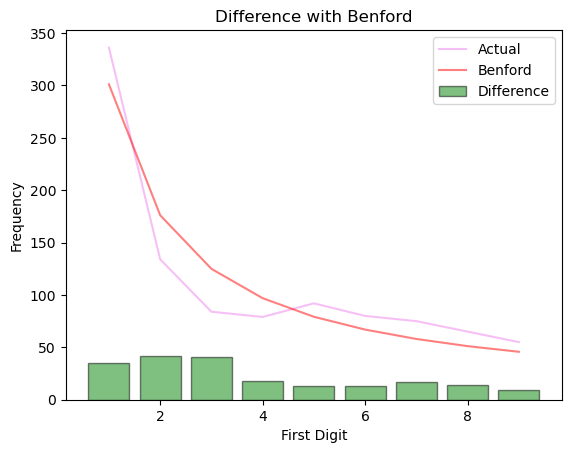

In [76]:
analyzer.show_benford_diff()

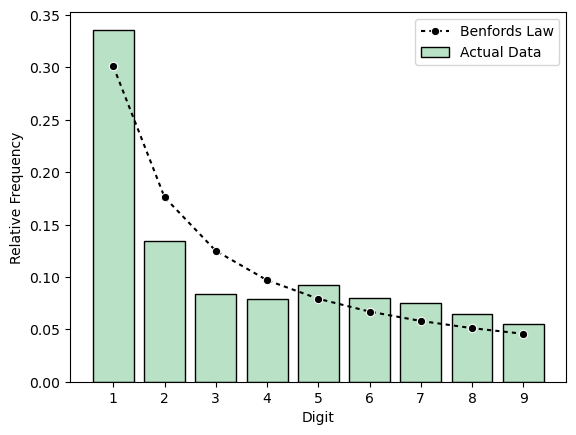

In [77]:
analyzer.show_benford_diff_2()